# Набор данных с комментариями

## Постановка задачи

Нужно разработать модель классификации комментариев по их тональности - положительные или отрицательные, на основе размеченного датасета.  

#### Основные этапы:  
1. Подготовка данных  
   - Определение структуры набора данных (текст + тональность).  
2. Предобработка текстов  
   - Очистка от шума (стоп-слова, пунктуация, цифры). 
   - Нижний регистр, лемматизация.    
3. Анализ языковых особенностей  
   - Построение облаков слов и тематическое моделирование (LDA) для выявления специфичных слов.  
4. Векторизация и классификация  
   - Преобразование текстов в числовые векторы (TF-IDF).  
   - Обучение и сравнение 3+ моделей нейроннх сетей с оценкой через метрики (accuracy, F1-score). 

## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import pymorphy3
import pyLDAvis

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, LSTM, GRU, Reshape, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## 1. Определить необходимые поля и создать структуру набора данных.

In [2]:
df = pd.read_csv("labeled.csv")

Загружаем данные из файла формата csv и сохраняем в дата-фрейм

In [3]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Набор данных содержит комментарии на руссом языке с соответствующей разметкой тональнсти. 

**Описание данных**
- comment - комментарии на русском языке;
- toxic - тональность соответсвующего комментария.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [5]:
df.duplicated().sum()

np.int64(0)

Можно заметить в датасете у нас 14412 строк и 2 признака. Пустых значений нет. Типы данных у признаков object и float. Дубликатов нет.

<Axes: xlabel='toxic'>

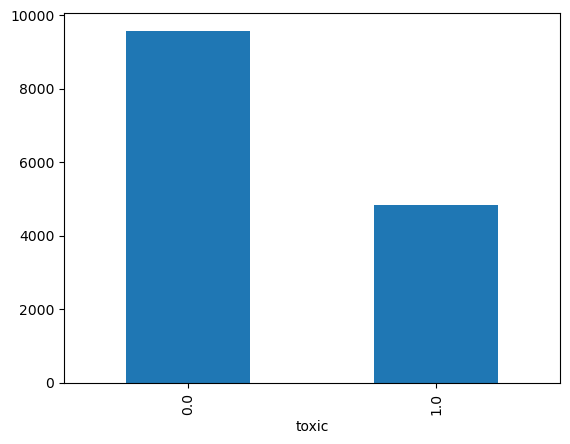

In [6]:
df['toxic'].value_counts().plot(kind='bar')

Построили график, чтобы просмотреть распределение тональности. Можно отметить, что больше всего положительных комментариев.

In [7]:
df['toxic'].value_counts()

toxic
0.0    9586
1.0    4826
Name: count, dtype: int64

## 2. Предварительная обработка текста

In [8]:
df.isnull().sum()

comment    0
toxic      0
dtype: int64

In [9]:
import string
st = '\xa0—'
custom_punctuation = string.punctuation + '«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])
    
def remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in custom_punctuation])
    
def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])
    
def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

Прописали метод для удаления знаков пунктуации и цифр

In [10]:
df['prep_comment'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(text.lower())))) for text in df['comment']]

Применили метод и сохранили изменения в новом признаке

In [11]:
df.head()

,comment,toxic,prep_comment
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдовто за что дебилы бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...


In [12]:
russian_stopwords = stopwords.words("russian")

In [13]:
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который','которые','которых','свой','своём','всем','всё','её','оба','ещё','должный','должные','должных'])

In [14]:
def remove_stopwords(text):
    if not isinstance(text, str):
        return text
    
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in russian_stopwords]
    
    return ' '.join(filtered_words)

In [15]:
df['prep_comment_1'] = df['prep_comment'].apply(remove_stopwords)

In [16]:
df.head()

,comment,toxic,prep_comment,prep_comment_1
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдовто за что дебилы бл,верблюдовто дебилы бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохлы отдушина затюканого россиянина мол вон х...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собаке собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил оскорбление доказанный ф...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...


In [17]:
from nltk.stem import WordNetLemmatizer
morph = pymorphy3.MorphAnalyzer(lang='ru')

lemm_texts_list = []
for text in (df['prep_comment_1']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)

df['lemmatized_text'] = lemm_texts_list

In [18]:
df.head()

,comment,toxic,prep_comment,prep_comment_1,lemmatized_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдовто за что дебилы бл,верблюдовто дебилы бл,верблюдовто дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохлы отдушина затюканого россиянина мол вон х...,хохол отдушина затюканый россиянин мол вон хох...
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собаке собачья смерть,собака собачий смерть
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил оскорбление доказанный ф...,страница обновить дебил оскорбление доказать ф...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,убедить страничный пдф скрипаль отравить росси...


## 3. Тематическое моделирование

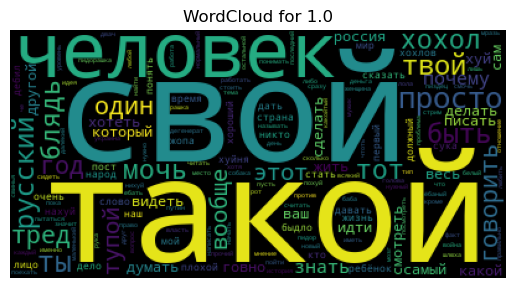

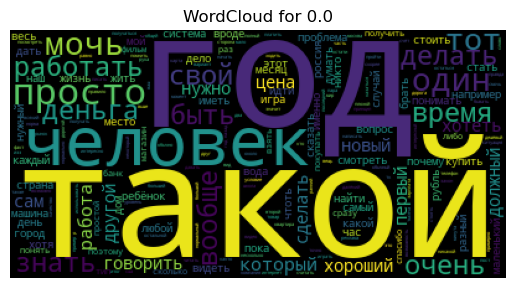

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, toxic):
    wordcloud = WordCloud().generate(text)
    plt.title(f'WordCloud for {toxic}')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

for lang in df['toxic'].unique():
    text = ' '.join(df[df['toxic'] == lang]['lemmatized_text'])
    plot_wordcloud(text, lang)

Вывели облако слов для тональностей.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['lemmatized_text'])

lda = LatentDirichletAllocation(n_components=5)
lda.fit(X)

# Вывод ключевых слов для каждой темы
for i, topic in enumerate(lda.components_):
    print(f'Topic {i}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['такой', 'фильм', 'просто', 'блядь', 'какой', 'быть', 'знать', 'смотреть', 'твой', 'ты']
Topic 1:
['самый', 'нужно', 'игра', 'цена', 'хороший', 'первый', 'говорить', 'либо', 'просто', 'такой']
Topic 2:
['вода', 'вроде', 'система', 'час', 'просто', 'такой', 'работа', 'работать', 'время', 'год']
Topic 3:
['такой', 'год', 'мочь', 'ребёнок', 'тот', 'другой', 'один', 'свой', 'жить', 'человек']
Topic 4:
['видео', 'место', 'время', 'знать', 'телефон', 'один', 'день', 'тред', 'такой', 'очень']


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

languages = df['toxic'].unique()

for lang in languages:
    print(f"\n=== Топ-темы для тональности: {lang} ===")
    
    lang_texts = df[df['toxic'] == lang]['lemmatized_text']
    
    vectorizer = CountVectorizer(max_features=500, 
                               ngram_range=(1, 2))
    
    X_lang = vectorizer.fit_transform(lang_texts)
    
    lda = LatentDirichletAllocation(n_components=6, 
                                  random_state=42)
    lda.fit(X_lang)
    
    # Выводим топ-слова для каждой темы
    for topic_idx, topic in enumerate(lda.components_):
        print(f"\nТема {topic_idx + 1}:")
        top_words = [vectorizer.get_feature_names_out()[i] 
                    for i in topic.argsort()[-10:]]
        print(", ".join(top_words))


=== Топ-темы для тональности: 1.0 ===

Тема 1:
сколько, пидорашка, тот, идти, такой, либо, хороший, хохлов, смотреть, хохол

Тема 2:
слово, шлюха, видеть, свой, хуй, жопа, сам, страна, год, такой

Тема 3:
один, хуйня, просто, свой, мой, говно, такой, сука, какой, тред

Тема 4:
лола, очень, говорить, терпеть, россия, место, почему, свой, просто, русский

Тема 5:
нормальный, дать, пидор, хотеть, читать, мочь, дебил, этот, тупой, человек

Тема 6:
нужно, весь, человек, дегенерат, просто, блядь, думать, быть, твой, ты

=== Топ-темы для тональности: 0.0 ===

Тема 1:
сколько, телефон, такой, пока, какой, человек, делать, фильм, год, ребёнок

Тема 2:
закон, банк, работать, хороший, стоить, платить, тот, свой, рубль, деньга

Тема 3:
очень, вообще, человек, знать, просто, спасибо, самый, быть, почему, такой

Тема 4:
первый, сша, последний, вроде, назад, жить, россия, страна, время, год

Тема 5:
дело, хотеть, видеть, другой, один, человек, день, мой, думать, просто

Тема 6:
либо, машина, работат

В отрицательных комментариях большинство споров связаны с оскорблениями национальностей, переходом на личности, матом и агрессивной негативной оценкой всего подряд без какой-либо аргументации.

В положительных/нейтральных комментариях большинство обсуждений связаны с бытовыми темами , финансами , семьёй и детьми, а также сравнением стран и рассуждениями о жизни — без агрессии и оскорблений, часто с выражением благодарности.

# 4. Векторизация текста

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = tfidf.fit_transform(df['lemmatized_text'])
y = df['toxic']

In [23]:
X.shape

(14412, 5000)

In [24]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 162020 stored elements and shape (14412, 5000)>
  Coords	Values
  (0, 789)	1.0
  (1, 4746)	0.267395669194846
  (1, 3646)	0.3796088657025208
  (1, 1968)	0.35930345261357705
  (1, 462)	0.35017291474067835
  (1, 4744)	0.6010694013934255
  (1, 2830)	0.26379868592373035
  (1, 3219)	0.3190649650327168
  (2, 3935)	0.5112930913438828
  (2, 3936)	0.6770487058333738
  (2, 3904)	0.5293244984632482
  (3, 789)	0.3121290379965013
  (3, 4164)	0.3716508285964818
  (3, 2499)	0.3836017457137721
  (3, 890)	0.3577155618319979
  (3, 4645)	0.2820118591918714
  (3, 4852)	0.3132621970281713
  (3, 2794)	0.2618417206218472
  (3, 322)	0.3168192390797444
  (3, 4286)	0.2587658586912789
  (3, 951)	0.27528389601683234
  (4, 4472)	0.5852959647284084
  (4, 3645)	0.3553515429464827
  (4, 960)	0.3251291907531036
  (4, 3433)	0.3940839143659248
  :	:
  (14410, 4815)	0.25627532363256933
  (14410, 3488)	0.2371296240551593
  (14410, 3979)	0.2811001543810372
  (144

Посмотерели вес каждого слова в наборе данных

In [25]:
tfidf.get_feature_names_out()[:100]

array(['and', 'boeing', 'crimes', 'facebook', 'gifx', 'https', 'it', 'of',
       'phd', 'ps', 'samsung', 'state', 'the', 'usb', 'wifi', 'windows',
       'yota', 'абзац', 'абонент', 'абсолютно', 'абсолютный', 'абу',
       'аварийный', 'авария', 'аватарка', 'аватарка истекать', 'август',
       'авиакомпания', 'австралия', 'авто', 'автобус', 'автомат',
       'автоматически', 'автоматический', 'автомобиль', 'автор',
       'авторитет', 'ага', 'агент', 'агентство', 'агрессивность',
       'агрессивный', 'агрессия', 'ад', 'адекватный', 'админ',
       'администрация', 'адрес', 'аж', 'азиат', 'азиатский', 'азия', 'ай',
       'ай ай', 'ай просто', 'айфон', 'академик', 'академия', 'аккаунт',
       'аккумулятор', 'аккуратно', 'акт', 'активировать', 'активно',
       'активность', 'активный', 'актриса', 'актуальный', 'актёр',
       'акция', 'алгоритм', 'александр', 'али', 'алкаш', 'алкоголь',
       'аллергия', 'алсый', 'альбом', 'альтернатива', 'америка',
       'американец', 'американск

Вывели первые 100 слов из списка, после векторизации

## 5. Классификация

## Разделение данных:

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
)

## Обучение моделей

### Dense Neural Network (базовая)

In [27]:
model_1 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [29]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,473 (5.04 MB)

 Trainable params: 1,321,473 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [31]:
history_1 = model_1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30


D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7312 - auc: 0.7763 - loss: 0.5180 - precision: 0.6892 - recall: 0.3279

D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8060 - auc: 0.8771 - loss: 0.4144 - precision: 0.7900 - recall: 0.5748 - val_accuracy: 0.8547 - val_auc: 0.9172 - val_loss: 0.3391 - val_precision: 0.7956 - val_recall: 0.7572
Epoch 2/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9276 - auc: 0.9759 - loss: 0.1849 - precision: 0.8856 - recall: 0.9005 - val_accuracy: 0.8500 - val_auc: 0.9130 - val_loss: 0.3735 - val_precision: 0.7815 - val_recall: 0.7611
Epoch 3/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9675 - auc: 0.9948 - loss: 0.0842 - precision: 0.9385 - recall: 0.9664 - val_accuracy: 0.8452 - val_auc: 0.8994 - val_loss: 0.5279 - val_precision: 0.7745 - val_recall: 0.7533
Epoch 4/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9856 - auc: 0.9989 - loss: 0.0395 - precision: 0.9696 - recall: 0.9880 - val_accuracy: 0.8356 - val_auc: 0.8924 - val_loss: 0.6521 - val_precision: 0.7440 - val_recall: 0.7702
Epoch 5/30
289/289 ━━━━━━━━━━━━━━━━━━━━

In [32]:
from sklearn.metrics import classification_report

y_pred_proba = model_1.predict(X_test)

y_pred_binary = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      1918
         1.0       0.81      0.77      0.79       965

    accuracy                           0.86      2883
   macro avg       0.85      0.84      0.84      2883
weighted avg       0.86      0.86      0.86      2883



### LSTM

In [33]:
texts = df['lemmatized_text'].values
y = df['toxic'].values

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [35]:
max_len = 100
X_pad = pad_sequences(sequences, maxlen=max_len)

In [36]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_pad, y, test_size=0.2, random_state=42, stratify=y
)

In [37]:
model_lstm = Sequential([
    Input(shape=(max_len,)),
    Embedding(10000, 128),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [38]:
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [39]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,521 (5.08 MB)

 Trainable params: 1,331,521 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [41]:
history_lstm = model_lstm.fit(
    X_train_1, y_train_1,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20


D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6964 - auc_1: 0.6730 - loss: 0.5843 - precision_1: 0.6304 - recall_1: 0.2422

D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.7652 - auc_1: 0.8183 - loss: 0.4804 - precision_1: 0.7488 - recall_1: 0.4517 - val_accuracy: 0.8617 - val_auc_1: 0.9240 - val_loss: 0.3331 - val_precision_1: 0.7811 - val_recall_1: 0.8107
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9185 - auc_1: 0.9685 - loss: 0.2113 - precision_1: 0.8807 - recall_1: 0.8756 - val_accuracy: 0.8569 - val_auc_1: 0.9196 - val_loss: 0.3469 - val_precision_1: 0.8036 - val_recall_1: 0.7533
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9571 - auc_1: 0.9897 - loss: 0.1179 - precision_1: 0.9357 - recall_1: 0.9363 - val_accuracy: 0.8565 - val_auc_1: 0.9115 - val_loss: 0.4446 - val_precision_1: 0.8184 - val_recall_1: 0.7298
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9771 - auc_1: 0.9964 - loss: 0.0657 - precision_1: 0.9637 - recall_1: 0.9683 - val_accuracy: 0.8578 - val_auc_1: 0.9083 - val_loss: 0.5392 - val_precision_1: 0.8008 - val_reca

In [42]:
y_pred_proba_lstm = model_lstm.predict(X_test_1)

y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

print(classification_report(y_test_1, y_pred_lstm))

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      1918
         1.0       0.78      0.83      0.80       965

    accuracy                           0.87      2883
   macro avg       0.85      0.86      0.85      2883
weighted avg       0.87      0.87      0.87      2883



### GRU (Gated Recurrent Unit)

In [43]:
model_gru = Sequential([
    Input(shape=(max_len,)),
    Embedding(10000, 128),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [44]:
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [45]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319,361 (5.03 MB)

 Trainable params: 1,319,361 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_gru = model_gru.fit(
    X_train_1, y_train_1,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20


D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7086 - auc_2: 0.6900 - loss: 0.5684 - precision_2: 0.6252 - recall_2: 0.2727

D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.7749 - auc_2: 0.8289 - loss: 0.4696 - precision_2: 0.7463 - recall_2: 0.4989 - val_accuracy: 0.8634 - val_auc_2: 0.9161 - val_loss: 0.3455 - val_precision_2: 0.8443 - val_recall_2: 0.7219
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9188 - auc_2: 0.9690 - loss: 0.2100 - precision_2: 0.8833 - recall_2: 0.8733 - val_accuracy: 0.8591 - val_auc_2: 0.9177 - val_loss: 0.3601 - val_precision_2: 0.7921 - val_recall_2: 0.7807
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9567 - auc_2: 0.9894 - loss: 0.1176 - precision_2: 0.9346 - recall_2: 0.9367 - val_accuracy: 0.8539 - val_auc_2: 0.9115 - val_loss: 0.4411 - val_precision_2: 0.7975 - val_recall_2: 0.7507


In [47]:
y_pred_proba_gru = model_gru.predict(X_test_1)

y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)

print(classification_report(y_test_1, y_pred_gru))

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1918
         1.0       0.83      0.72      0.77       965

    accuracy                           0.86      2883
   macro avg       0.85      0.83      0.84      2883
weighted avg       0.86      0.86      0.86      2883



### Сравнительный анализ

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

def get_metrics(y_true, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    
    return {
        'Модель': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4),
        'AUC': round(auc, 4)
    }

y_pred_proba_gru = model_gru.predict(X_test, verbose=0)
y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)
results.append(get_metrics(y_test, y_pred_gru, y_pred_proba_gru, 'GRU + Embedding'))

y_pred_proba_lstm = model_lstm.predict(X_test, verbose=0)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)
results.append(get_metrics(y_test, y_pred_lstm, y_pred_proba_lstm, 'LSTM + Embedding'))

y_pred_proba = model_1.predict(X_test, verbose=0)
y_pred_binary = (y_pred_proba > 0.5).astype(int)
results.append(get_metrics(y_test, y_pred_binary, y_pred_proba, 'Dense (TF-IDF)'))

results_df = pd.DataFrame(results)

results_df = results_df.sort_values('F1-score', ascending=False).reset_index(drop=True)

print("📊 Сравнительная таблица моделей:")
print(results_df.to_string(index=False))

📊 Сравнительная таблица моделей:
          Модель  Accuracy  Precision  Recall  F1-score    AUC
  Dense (TF-IDF)    0.8616     0.8076  0.7699    0.7883 0.9182
 GRU + Embedding    0.3347     0.3347  1.0000    0.5016 0.4995
LSTM + Embedding    0.3347     0.3347  1.0000    0.5016 0.5010


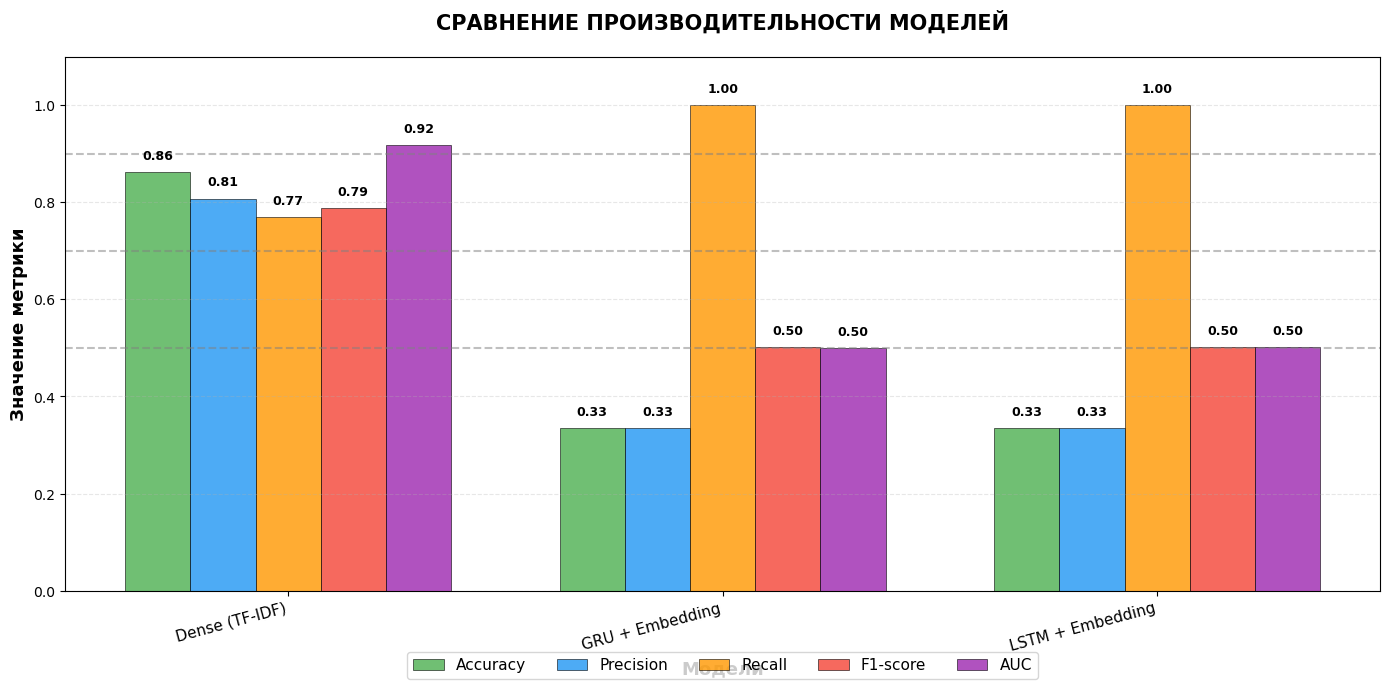

In [49]:
# График сравнения со значениями сверху
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(results_df))
width = 0.15
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#F44336', '#9C27B0']

# Рисуем столбцы
for i, metric in enumerate(metrics):
    bars = ax.bar(x + i*width, results_df[metric], width, 
                  label=metric, color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # ДОБАВЛЯЕМ ЗНАЧЕНИЯ СВЕРХУ СТОЛБЦОВ
    for bar, val in zip(bars, results_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Настройки осей
ax.set_xlabel('Модели', fontsize=13, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=13, fontweight='bold')
ax.set_title('СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛЕЙ', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Модель'], rotation=15, ha='right', fontsize=11)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Добавляем разделительные линии
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Сохранение модели

In [50]:
model_1.save('model_1.keras')

D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implemen

In [52]:
import pickle

with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Вывод

Лучшая модель: Dense (TF-IDF)

1. Высокая точность (86%)
Правильно классифицирует 86% всех комментариев — отличный результат.

2. Сбалансированные метрики
Precision (0.81) и Recall (0.77) близки — модель не перекошена в один класс.

3. Хороший F1-score (0.79)
Гармоническое среднее precision и recall — надежный показатель качества.

4. Отличный AUC (0.92)
Модель отлично разделяет токсичные и нетоксичные комментарии.

5. Работает, а не угадывает
В отличие от GRU/LSTM, которые просто ставят всем "токсичный".